In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_9165/859329180.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Overview



### Part 1: Priming the data

Different datasets have certain marker values associated with certain locations at different levels (e.g., the neighbourhood level or sub-district level). These values are essential for merging datasets (for example, one dataset may contain a neighbourhood's number of cars, and another a tree and which neighbourhood it is in)

Not every dataset uses the same marker values, and these marker values can have different column names, so I first need to standardise it all. I'm also making some functions that will streamline the data cleaning process a bit.

In [2]:
# functions for data cleaning
# return the proportion of nan each column in the data
def na_proportion(series: pd.Series):
    return series.isna().sum() / len(series)

# returns a dataframe without the columns that have higher proportion of na 
# than threshold. The reason I'm doing this is because drop.na could remove
# very large amounts of data just due to one a column being mostly nans. So
# columns full of nans get removed. 
# default threshold: 40% of nan means removal
def stripped_threshold_na_columns(df: pd.DataFrame, threshold = 0.4):
    df_return = pd.DataFrame()
    for column in df.columns:
        if na_proportion(df[column]) < threshold:
            df_return[column] = df[column]
    return df_return

# if a value occurs less than n times in a series, replace it with placeholder
def replace_less_than_n_values(series: pd.Series, n = 10, placeholder = np.nan):
    value_counts = series.value_counts()
    values_to_replace = value_counts[value_counts < n].index
    return series.replace(to_replace=values_to_replace, value=placeholder)

# returns the n most common values in a series (by default the 10 most common)
def most_common_n_values(series: pd.Series, n = 10):
    return series.value_counts()[:n].index.tolist()


# return a series with its least common values converted to a different value
# nans are also replaceable
# by default, the string 'other'
def otherise(value, most_common_values, other, nan_replace):
    if value in most_common_values:
        return value
    if value is np.nan:
        return nan_replace
    return other

def otherise_less_common_values(
        series: pd.Series, 
        most_common_values, 
        other='other', 
        nan_replace = np.nan
    ):
    return series.apply(
        lambda value: otherise(value, most_common_values, other, nan_replace)
    )


In [3]:
# tree data
df_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
# amsterdam neighbourhood meta data, i.e. matching neighbourhood name with ID
df_buurt_meta = pd.read_csv('data/gebieden-buurten-2024-03-12T12 09 07.653588.csv')
# amsterdam sub-district meta data, to match each neighbourhood with its sub-district
df_wijk_meta = pd.read_csv('data/gebieden_wijken.csv')
# amsterdam district meta data, to match each neighbourhood with its district
# df_staddeel_meta = pd.read_csv('data/INDELING_STADSDEEL.csv')

In [4]:
# standardise names of neighbourhood id column so we can merge on that column
neighbourhood_id_column = 'buurt_id'
subdistrict_id_column = 'wijk_id'
district_id_column = 'staddeel_id'


# rename buurt id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Identificatie': neighbourhood_id_column}
)
df_trees = df_trees.rename(
    columns={'Gbdbuurtid': neighbourhood_id_column}
)

# rename wijk id columns in all datasets to be the same for merging
df_buurt_meta = df_buurt_meta.rename(
    columns={'Ligtinwijkid': subdistrict_id_column}
)
df_wijk_meta = df_wijk_meta.rename(
    columns={
        'Identificatie': subdistrict_id_column,
        'Ligtinstadsdeelid': district_id_column,
    }
)


In [5]:
# match each buurt (neighbourhood) with its associated wijk (sub-district)
df_buurt_simple = df_buurt_meta[[
    neighbourhood_id_column, subdistrict_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_buurt_simple = df_buurt_simple.rename(
    columns={
        'Naam': 'Naam_buurt',
        'Code': 'Code_buurt',
        'Cbscode': 'Cbscode_buurt',
        'Geometrie': 'Geometrie_buurt'
    }
)

df_wijk_simple = df_wijk_meta[[
    subdistrict_id_column, 'Naam', 'Code', 'Cbscode', 'Geometrie'
]]

df_wijk_simple = df_wijk_simple.rename(
    columns={
        'Naam': 'Naam_wijk',
        'Code': 'Code_wijk',
        'Cbscode': 'Cbscode_wijk',
        'Geometrie': 'Geometrie_wijk'
    }
)

df_location_data = pd.merge(df_buurt_simple, df_wijk_simple, on=subdistrict_id_column)

Now we can merge datasets based on shared location markers. Yay!

### Part 2: Tree data

I am making a dataset which contains a list of trees from Amsterdam's tree census and some information associated with each tree. This is the cleaning up of that data.

#### Removing columns with too many nans, then removing nans
To prevent removing too much data, I'm discarding columns that have too many nans (the diameter column for example), making exceptions only for interesting data.

Then I remove any row with a nan value for the model.

It's possible that I'm skewing the data in a way that will affect my model (example: maybe there is a specific relationship between height and species that's only found in trees that also have a nan value somewhere) but I don't have time to look at that and it's probably beyond the requirements of the assignment.

In [6]:
# clean up tree data
# removing nans
# we want to remove columns that have too many nans so that we don't reduce
# the entire dataset too much by using .dropna
# I make exceptions for growth ground and diameter statistics since these seem
# useful for certain models
growth_ground = df_trees['Standplaatsgedetailleerd']
diameter = df_trees['Stamdiameterklasse']

print(f'shape before dropna: {df_trees.shape}')

df_trees = stripped_threshold_na_columns(df_trees)
df_trees['growth_ground'] = growth_ground
df_trees['diameter'] = diameter
df_trees.dropna(inplace=True)

print(f'shape after dropna: {df_trees.shape}')


shape before dropna: (286909, 14)
shape after dropna: (28211, 14)


#### Height data

Height data is unfortunately not recorded exactly but given as an estimated range (like "between 6 and 9").

I'm going to store height in two ways: in one instance I will take the average (so between 6 and 9 gives me 7.5), in anotehr instance I will take a random value (so a random value between 6 and 9).

I will try running a model for both the "fixed" value and the "random" values, I am curious what that will result in.

In [7]:
# height
# we only have estimation measures for tree height (like "6 tot 9 m.") :(
# There are some limitations from applying a linear regression model
# to height that is calculated this way.
def extract_height_data(data):
    if data == 'a. tot 6 m.':
        return 3
    if data == 'b. 6 tot 9 m.':
        return 7.5
    if data == 'c. 9 tot 12 m.':
        return 10.5
    if data == 'd. 12 tot 15 m.':
        return 13.5
    if data == 'e. 15 tot 18 m.':
        return 16.5
    if data == 'f. 18 tot 24 m.':
        return 21
    if data == 'g. 24 m. en hoger':
        return 24
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_fixed'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data(x)
)

df_trees.dropna(inplace=True)




In [8]:
import random
def extract_height_data_randomised(data):
    if data == 'a. tot 6 m.':
        return random.uniform(0, 6)
    if data == 'b. 6 tot 9 m.':
        return random.uniform(6, 9)
    if data == 'c. 9 tot 12 m.':
        return random.uniform(9, 12)
    if data == 'd. 12 tot 15 m.':
        return random.uniform(12, 15)
    if data == 'e. 15 tot 18 m.':
        return random.uniform(15, 18)
    if data == 'f. 18 tot 24 m.':
        return random.uniform(18, 24)
    if data == 'g. 24 m. en hoger':
        return random.uniform(24, 30)
    # if not any of the above return nan
    return np.nan

df_trees['tree_height_random'] = df_trees['Boomhoogteklasseactueel'].apply(
    lambda x: extract_height_data_randomised(x)
)

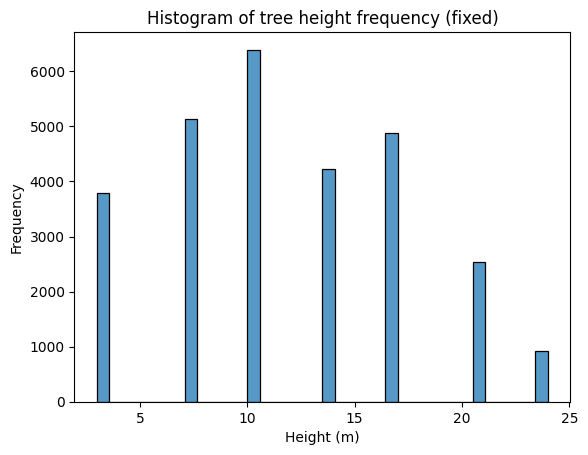

In [9]:
sns.histplot(df_trees['tree_height_fixed'])
plt.title("Histogram of tree height frequency (fixed)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")# visualise tree height distribution
plt.show()


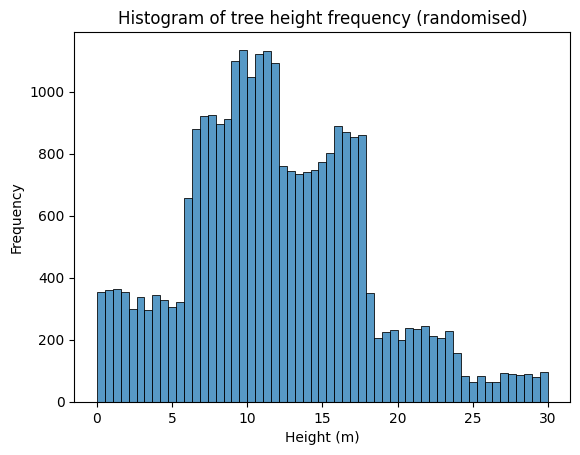

In [10]:
sns.histplot(df_trees['tree_height_random'])
plt.title("Histogram of tree height frequency (randomised)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")# visualise tree height distribution
plt.show()


##### Shape of height data

It looks like a left-skewed, normal-ish distribution. I would guess that if the data contained the actual height of trees, the data would look a bit more like a normal distribution.

### Diameter
Similar cleaning process for diameter

In [11]:
df_trees['diameter'].value_counts()

diameter
0,1 tot 0,2 m.    9444
0,3 tot 0,5 m.    7470
0,2 tot 0,3 m.    6807
0,5 tot 1 m.      3847
1,0 tot 1,5 m.     302
Name: count, dtype: int64

In [12]:
def extract_diameter_data(diameter):
    if diameter == '0,1 tot 0,2 m.':
        return 0.15
    if diameter == '0,2 tot 0,3 m.':
        return 0.25
    if diameter == '0,3 tot 0,5 m.':
        return 0.4
    if diameter == '0,5 tot 1 m.':
        return 0.75
    if diameter == '1,0 tot 1,5 m.':
        return 1.25

df_trees['diameter'] = df_trees['diameter'].apply(
    lambda x: extract_diameter_data(x)
)

df_trees['diameter'].value_counts()

diameter
0.15    9444
0.40    7470
0.25    6807
0.75    3847
1.25     302
Name: count, dtype: int64

In [13]:
# neighbourhood that tree is in (ID)
print(df_trees['buurt_id'].value_counts())

buurt_id
3.630980e+12    1880
3.630980e+12    1111
3.630980e+12     820
3.630980e+12     653
3.630980e+12     615
                ... 
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
3.630980e+12       1
Name: count, Length: 250, dtype: int64


In [14]:
# tree administrator ('Typebeheerderplus')
# categorical
print(df_trees['Typebeheerderplus'].value_counts())
admin_threshold = 15
df_trees['tree_admin'] = replace_less_than_n_values(
    df_trees['Typebeheerderplus'],
    admin_threshold
)
print(f'proportion of nan for admin after removal: {na_proportion(df_trees['Typebeheerderplus'])}')

df_trees.dropna(inplace=True)

Typebeheerderplus
R&E_VOR_Bomen                     26264
Recreatieschap Noord-Holland       1384
R&E_VOR_Groen                        82
Gemeente Amsterdam, rve Sport        74
Rijkswaterstaat                      24
Gemeentelijk Vastgoed                17
Stichting                             8
Havenbedrijf                          6
Amsterdamse bos - eigen dienst        4
Volkstuinpark                         3
Woningcorporatie                      2
Schooltuinen                          1
Natuurlijk persoon                    1
Name: count, dtype: int64
proportion of nan for admin after removal: 0.0


In [15]:
print(df_trees['tree_admin'].value_counts())

tree_admin
R&E_VOR_Bomen                    26264
Recreatieschap Noord-Holland      1384
R&E_VOR_Groen                       82
Gemeente Amsterdam, rve Sport       74
Rijkswaterstaat                     24
Gemeentelijk Vastgoed               17
Name: count, dtype: int64


In [16]:
# municipality that owns the trees
print(df_trees['Typeeigenaarplus'].value_counts())
# the overwhelming majority of trees are owned by amsterdam.
# let's have values for just "amsterdam" and "not amsterdam"
amsterdam_ownership = ['Gemeente Amsterdam']
df_trees['tree_municipality'] = otherise_less_common_values(
    df_trees['Typeeigenaarplus'], amsterdam_ownership
)

Typeeigenaarplus
Gemeente Amsterdam       25498
Gemeente Weesp            2332
Gemeente Diemen              8
Gemeente Ouder-Amstel        7
Name: count, dtype: int64


In [17]:
df_trees['tree_municipality'].value_counts()

tree_municipality
Gemeente Amsterdam    25498
other                  2347
Name: count, dtype: int64

In [18]:
# tree planting year
print(
    f'proportion of nan for planting year: {na_proportion(df_trees['Jaarvanaanleg'])}'
)
# not many nans :)
print(df_trees['Jaarvanaanleg'].value_counts())
# lots of zeros :(
# Removing all the rows with nonsensical years
year_threshold = 1500 # let's admit really old trees because they are awesome
df_trees = df_trees[df_trees.Jaarvanaanleg > year_threshold]
df_trees.rename(columns={
    'Jaarvanaanleg': 'year_planted'
}, inplace=True)


proportion of nan for planting year: 0.0
Jaarvanaanleg
1980.0    1708
1970.0    1603
1985.0    1590
1996.0    1392
1990.0    1101
          ... 
1929.0       1
1880.0       1
1924.0       1
2022.0       1
1934.0       1
Name: count, Length: 114, dtype: int64


In [19]:
df_trees['age'] = 2024 - df_trees['year_planted']

<Axes: xlabel='age', ylabel='Count'>

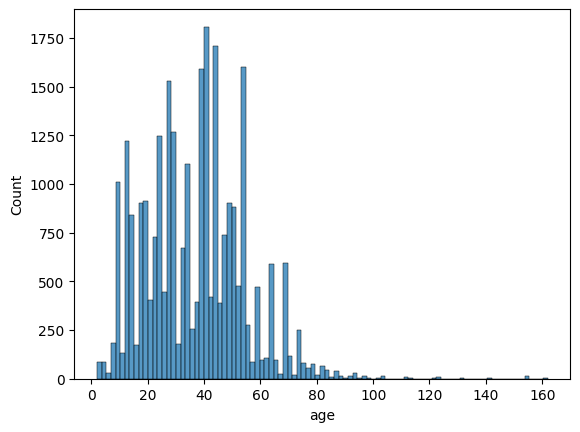

In [20]:
sns.histplot(df_trees['age'])

In [21]:
# there are three columns for the species of the tree
# Soortnaam: specific latin name species
print(df_trees['Soortnaam'].value_counts())
# Sortnaamkort/Sortnaamtop are for grouped species (they're the same)
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
print(df_trees['Soortnaamkort'].value_counts())
print(f'nan proportion Soortnaamtop: {na_proportion(df_trees['Soortnaamtop'])}')
print(df_trees['Soortnaamtop'].value_counts())

# let's choose both, even if they will by definition be highly correlated in some ways

Soortnaam
Fraxinus excelsior           953
Alnus glutinosa              929
Quercus robur                917
Platanus hispanica           819
Ulmus hollandica 'Vegeta'    780
                            ... 
Malus atrosanguinea            1
Malus 'Butterball'             1
Catalpa ovata                  1
Acer pensylvanicum             1
Morus alba 'Pendula'           1
Name: count, Length: 568, dtype: int64
nan proportion Soortnaamkort: 0.0
Soortnaamkort
Tilia        3735
Ulmus        3354
Acer         2803
Fraxinus     2371
Alnus        1631
             ... 
Aralia          1
Toona           1
Hibiscus        1
Tetradium       1
Nyssa           1
Name: count, Length: 72, dtype: int64
nan proportion Soortnaamtop: 0.0
Soortnaamtop
Linde (Tilia)     3735
Iep (Ulmus)       3354
Esdoorn (Acer)    2803
Es (Fraxinus)     2371
Els (Alnus)       1631
                  ... 
Aralia               1
Hibiscus             1
Tetradium            1
Nyssa                1
Frangula             1
Name:

In [22]:
# Soortnaam (exact species)
# How many species are there?
print(f'number of species: {df_trees['Soortnaam'].value_counts().shape}')
# let's remove trees which species there are too few of
species_threshold = 10
df_trees['species'] = replace_less_than_n_values(
    df_trees['Soortnaam'],
    species_threshold
)
# how much did that remove?
print(f'number of species after removal: {df_trees['species'].value_counts().shape}')
print(f'nan proportion Soortnaam after removal: {na_proportion(df_trees['species'])}')
df_trees.dropna(inplace=True)

number of species: (568,)
number of species after removal: (242,)
nan proportion Soortnaam after removal: 0.03937350445943006


In [23]:
# Soortnaamkort (species group)
# How many groups are there?
print(f'number of species groups: {df_trees['Soortnaamkort'].value_counts().shape}')
# proportion of nan?
print(f'nan proportion Soortnaamkort: {na_proportion(df_trees['Soortnaamkort'])}')
# let's remove trees which species group there are too few of
gr_species_threshold = 10
df_trees['species_group'] = replace_less_than_n_values(
    df_trees['Soortnaamkort'],
    gr_species_threshold
)
# how much did that remove?
print(f'number of species groups after removal: {df_trees['species_group'].value_counts().shape}')
print(f'nan proportion species_group after removal: {na_proportion(df_trees['species_group'])}')
df_trees.dropna(inplace=True)


number of species groups: (47,)
nan proportion Soortnaamkort: 0.0
number of species groups after removal: (47,)
nan proportion species_group after removal: 0.0


In [24]:
# Typeobject (status of the object)
print(f'{df_trees['Typeobject'].value_counts()}')
# seems fine already. will just nan up the one boomstam_algemeen
df_trees['tree_treatment'] = replace_less_than_n_values(df_trees['Typeobject'])
df_trees.dropna(inplace=True)

Typeobject
Boom niet vrij uitgroeiend    22269
Boom vrij uitgroeiend          2314
Knotboom                        637
Gekandelaberde boom             515
Vormboom                        460
Stobbe                          296
Leiboom                           5
Name: count, dtype: int64


In [25]:
# Typesoortnaam (the sort of thing that this is)
print(df_trees['Typesoortnaam'].value_counts())
# we are only interested in trees
only_trees = most_common_n_values(df_trees['Typesoortnaam'], n = 1)
df_trees['plant_type'] = otherise_less_common_values(
    df_trees['Typesoortnaam'],
    only_trees,
    other = np.nan
)
df_trees.dropna(inplace=True)

Typesoortnaam
Bomen       26489
Algemeen        2
Name: count, dtype: int64


In [26]:
# number of trees left
print(df_trees.shape)

(26489, 23)


In [27]:
df_with_location = pd.merge(df_trees, df_location_data, on=neighbourhood_id_column)
display(df_with_location.sample(10).head())
print(df_with_location.columns)

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,plant_type,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk
6517,993345,3.630980e+12,SRID=28992;POINT (120306.67 486008.44),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1975.0,Tilia europaea 'Zwarte Linde',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000058,Vondelpark-Oost,KD01,BU0363KD01,"SRID=28992;POLYGON ((120255.353 485922.895, 12...",Museumkwartier,KD,WK0363KD,"SRID=28992;POLYGON((120906.182 485766.041,1209..."
26356,4131490,3.630980e+12,SRID=28992;POINT (126414.18177605 480588.99409...,R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,2021.0,Amelanchier lamarckii,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000113,Gooise Kant,TH01,BU0363TH01,"SRID=28992;POLYGON ((126542.26 480634.381, 126...",K-buurt,TH,WK0363TH,"SRID=28992;POLYGON((127640.202 481122.04,12760..."
5394,989008,3.630980e+12,SRID=28992;POINT (118576.36 485379.22),R&E_VOR_Bomen,b. 6 tot 9 m.,Gemeente Amsterdam,1980.0,Robinia pseudoacacia 'Umbraculifera',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000055,Surinamepleinbuurt,KA02,BU0363KA02,"SRID=28992;POLYGON ((118683.568 485536.02, 118...",Hoofddorppleinbuurt,KA,WK0363KA,"SRID=28992;POLYGON((118559.646 484917.027,1186..."
5784,990437,3.630980e+12,SRID=28992;POINT (120222.28 485575.38),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,1992.0,Robinia pseudoacacia 'Bessoniana',Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000058,Concertgebouwbuurt,KD03,BU0363KD03,"SRID=28992;POLYGON ((120350.164 485705.437, 12...",Museumkwartier,KD,WK0363KD,"SRID=28992;POLYGON((120906.182 485766.041,1209..."
13752,1069596,3.630980e+12,SRID=28992;POINT (120227.58 492278.66),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1985.0,Acer pseudoplatanus,Boom niet vrij uitgroeiend,Bomen,...,Bomen,3630970000088,Tuindorp Oostzaan-West,NC01,BU0363NC01,"SRID=28992;POLYGON ((120445.325 492484.868, 12...",Tuindorp Oostzaan,NC,WK0363NC,"SRID=28992;POLYGON((121989.715 491718.467,1218..."


Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'diameter', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk'],
      dtype='object')


In [28]:
# parking data
df_parking = pd.read_csv('data/parking_data_amsterdam.csv')


In [29]:
# some info about this dataset
print(f'shape of parking dataset: {df_parking.shape}')
print(f'columns: {df_parking.columns}')
parking_count_per_buurt = df_parking['buurtcode'].value_counts()
parking_per_neighbourhood = pd.DataFrame({
    'Code_buurt': parking_count_per_buurt.index,
    'parked_cars_in_neighbourhood': parking_count_per_buurt.values
})
print(parking_per_neighbourhood)


shape of parking dataset: (266622, 9)
columns: Index(['WKT', 'id', 'buurtcode', 'straatnaam', 'type', 'soort', 'e_type',
       'aantal', 'versiedatum'],
      dtype='object')
    Code_buurt  parked_cars_in_neighbourhood
0         KQ05                          2986
1         KR03                          2385
2         FH02                          2373
3         FA03                          2348
4         MN03                          2231
..         ...                           ...
497       AD08                             7
498       TA05                             6
499       NQ07                             4
500       FN03                             4
501       MP02                             2

[502 rows x 2 columns]


In [30]:
df_with_parking = pd.merge(
    df_with_location, 
    parking_per_neighbourhood,
    on='Code_buurt'
)
df_with_parking.dropna(inplace=True)
display(df_with_parking.sample(10).head())

,Id,buurt_id,Geometrie,Typebeheerderplus,Boomhoogteklasseactueel,Typeeigenaarplus,year_planted,Soortnaam,Typeobject,Typesoortnaam,...,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,parked_cars_in_neighbourhood
8172,1014277,3.630980e+12,SRID=28992;POINT (119794.83 486502.2),R&E_VOR_Bomen,e. 15 tot 18 m.,Gemeente Amsterdam,1978.0,Robinia pseudoacacia 'Bessoniana',Boom niet vrij uitgroeiend,Bomen,...,3630970000036,Borgerbuurt,ES02,BU0363ES02,"SRID=28992;POLYGON ((119907.181 486486.832, 11...",Van Lennepbuurt,ES,WK0363ES,"SRID=28992;POLYGON((119907.181 486486.832,1200...",521
19363,1123825,3.630980e+12,SRID=28992;POINT (115361.77 486338.2),R&E_VOR_Bomen,d. 12 tot 15 m.,Gemeente Amsterdam,2010.0,Platanus hispanica 'Tremonia',Boom niet vrij uitgroeiend,Bomen,...,3630970000049,Meer en Oever,FK02,BU0363FK02,"SRID=28992;POLYGON ((115519.313 486716.865, 11...",Osdorp-Oost,FK,WK0363FK,"SRID=28992;POLYGON((115829.329 485914.172,1157...",832
18481,1118743,3.630980e+12,SRID=28992;POINT (114199.16 484958.25),R&E_VOR_Bomen,a. tot 6 m.,Gemeente Amsterdam,2003.0,Betula utilis 'Doorenbos',Boom niet vrij uitgroeiend,Bomen,...,3630970000046,De Aker-Oost,FG03,BU0363FG03,"SRID=28992;POLYGON ((114441.219 485181.601, 11...",De Aker,FG,WK0363FG,"SRID=28992;POLYGON((114441.219 485181.601,1144...",1929
6141,994311,3.630980e+12,SRID=28992;POINT (119036.73 485093.22),R&E_VOR_Bomen,c. 9 tot 12 m.,Gemeente Amsterdam,1975.0,Tilia europaea 'Pallida',Gekandelaberde boom,Bomen,...,3630970000057,Willemsparkbuurt-Noord,KC02,BU0363KC02,"SRID=28992;POLYGON ((119626.547 485389.634, 11...",Willemspark,KC,WK0363KC,"SRID=28992;POLYGON((119626.547 485389.634,1196...",1173
3934,985118,3.630980e+12,SRID=28992;POINT (125322.63 481804.63),R&E_VOR_Bomen,f. 18 tot 24 m.,Gemeente Amsterdam,1985.0,Populus canescens 'De Moffart',Boom niet vrij uitgroeiend,Bomen,...,3630970000107,Venserpolder-Oost,TB02,BU0363TB02,"SRID=28992;POLYGON ((125245.509 481956.763, 12...",Venserpolder,TB,WK0363TB,"SRID=28992;POLYGON((125375.179 481721.988,1253...",1392


Text(0, 0.5, 'Frequency')

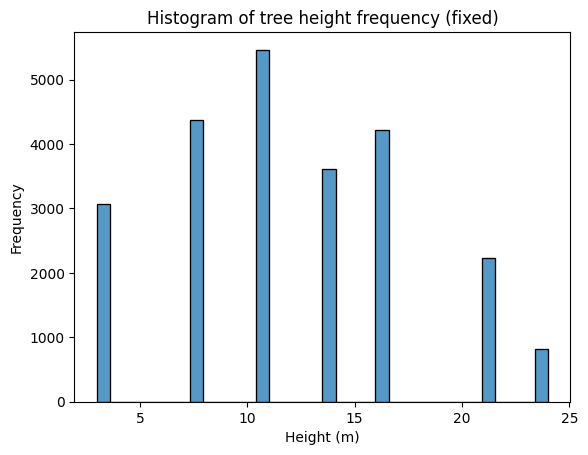

In [31]:
# let's plot the height of trees of the cleaned up dataset
sns.histplot(df_with_parking['tree_height_fixed'])
plt.title("Histogram of tree height frequency (fixed)")
plt.xlabel("Height (m)")
plt.ylabel("Frequency")

In [32]:
# last cleaning steps to make dataset smaller
df_with_parking.columns

Index(['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus',
       'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
       'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
       'Soortnaamtop', 'growth_ground', 'diameter', 'tree_height_fixed',
       'tree_height_random', 'tree_admin', 'tree_municipality', 'age',
       'species', 'species_group', 'tree_treatment', 'plant_type', 'wijk_id',
       'Naam_buurt', 'Code_buurt', 'Cbscode_buurt', 'Geometrie_buurt',
       'Naam_wijk', 'Code_wijk', 'Cbscode_wijk', 'Geometrie_wijk',
       'parked_cars_in_neighbourhood'],
      dtype='object')

In [33]:
# removing redundant columns
columns_to_drop = ['Id', 'buurt_id', 'Geometrie', 'Typebeheerderplus', 
                   'Boomhoogteklasseactueel', 'Typeeigenaarplus', 'year_planted',
                    'Soortnaam', 'Typeobject', 'Typesoortnaam', 'Soortnaamkort',
                    'Soortnaamtop', 'wijk_id', 'Code_buurt', 'Cbscode_buurt',
                    'Geometrie_buurt', 'Code_wijk', 'Cbscode_wijk',
                    'Geometrie_wijk', 'plant_type'
]
df_trees_final = df_with_parking.drop(columns=columns_to_drop)

In [34]:
df_trees_final.to_csv('data/clean_tree_data.csv')

### Part 3: Count tree data

Now I'd like to have a dataset on which the observed unit isn't a tree, but a neighbourhood. The variable we'll focus on for each neighbourhood is the number of trees in it.

In [35]:
# first let's get a recount of all the trees
df_all_trees = pd.read_csv('data/bomen-stamgegevens-2024-03-12T09 06 04.036291.csv')
df_all_trees = df_all_trees.rename(
    columns={'Gbdbuurtid': neighbourhood_id_column}
)
# associate each tree with its neighbourhood by name of neighbourhood
df_all_trees = pd.merge(df_all_trees, df_location_data, on=neighbourhood_id_column)

In [36]:
# nothing to 'Id', any column derived from these methods contains the same value, 
# which is the tree count
tree_count = df_all_trees.groupby('Naam_buurt').count()['Id']
df_tree_count = pd.DataFrame({
    'Naam_buurt': tree_count.index,
    'tree_count': tree_count.values,
})
df_tree_count = pd.merge(df_location_data, df_tree_count, on='Naam_buurt', how='left')
# if no single tree has been recorded in a neighbourhood, it will appear
# in the data as a NaN. let's assume that no tree recorded = 0 tree in neighbourhood
df_tree_count['tree_count'] = df_tree_count['tree_count'].fillna(0)
df_tree_count

,buurt_id,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,tree_count
0,3630980000467,3630970000101,Landelijk gebied Driemond,SA01,BU0363SA01,"SRID=28992;POLYGON ((129824.496 481758.331, 12...",Driemond,SA,WK0363SA,"SRID=28992;POLYGON((129824.496 481758.331,1297...",448.0
1,3630980000468,3630970000101,Dorp Driemond,SA02,BU0363SA02,"SRID=28992;POLYGON ((129988.603 480090.581, 12...",Driemond,SA,WK0363SA,"SRID=28992;POLYGON((129824.496 481758.331,1297...",580.0
2,3630980000527,3630970000115,Gaasperpark,TK02,BU0363TK02,"SRID=28992;POLYGON ((128465.49 480746.525, 128...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",298.0
3,3630980000528,3630970000115,Gaasperplas,TK03,BU0363TK03,"SRID=28992;POLYGON ((129270.769 480101.017, 12...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",75.0
4,3630980000526,3630970000115,L-buurt,TK01,BU0363TK01,"SRID=28992;POLYGON ((127661.221 479987.011, 12...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",2108.0
...,...,...,...,...,...,...,...,...,...,...,...
513,3630980000072,3630970000015,Leidsebuurt-Zuidwest,AH05,BU0363AH05,"SRID=28992;POLYGON ((120502.325 486513.823, 12...",De Weteringschans,AH,WK0363AH,"SRID=28992;POLYGON((122045.281 486069.645,1220...",40.0
514,3630980000073,3630970000015,Leidsebuurt-Zuidoost,AH06,BU0363AH06,"SRID=28992;POLYGON ((120628.541 486343.634, 12...",De Weteringschans,AH,WK0363AH,"SRID=28992;POLYGON((122045.281 486069.645,1220...",42.0
515,3630980000074,3630970000015,Den Texbuurt,AH07,BU0363AH07,"SRID=28992;POLYGON ((121551.417 485868.86, 121...",De Weteringschans,AH,WK0363AH,"SRID=28992;POLYGON((122045.281 486069.645,1220...",199.0
516,3630980000075,3630970000015,Frederikspleinbuurt,AH08,BU0363AH08,"SRID=28992;POLYGON ((122045.281 486069.645, 12...",De Weteringschans,AH,WK0363AH,"SRID=28992;POLYGON((122045.281 486069.645,1220...",339.0


<Axes: xlabel='tree_count', ylabel='Count'>

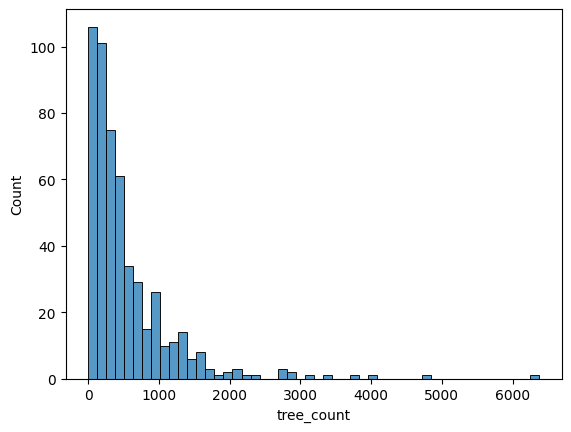

In [37]:
sns.histplot(df_tree_count['tree_count'])


Looks like a poisson regression will be ideal for this distribution, it's heavily skewed towards lower values and we have a few 0s.

In [38]:
# let's augment the data with the number of parked cars per neighbourhood
df_tree_count_cars = pd.merge(
    df_tree_count, parking_per_neighbourhood, on='Code_buurt', how='left'
) 
# no car recorded in neighbourhood = assume there are 0 cars in it
df_tree_count_cars['parked_cars_in_neighbourhood'] = df_tree_count_cars[
    'parked_cars_in_neighbourhood'].fillna(0)

In [39]:
# augment the data with number of unique species per neighbourhood
species_count = df_all_trees.groupby('Naam_buurt').nunique()['Soortnaam']
df_species_count = pd.DataFrame({
    'Naam_buurt': species_count.index,
    'species_count': species_count.values
})
df_tree_count_species = pd.merge(
    df_tree_count_cars, df_species_count, on='Naam_buurt', how='left'
)
# NaN species = 0 species
df_tree_count_species['species_count'] = df_tree_count_species['species_count'].fillna(0)

In [56]:
# augment data with area data for each neighbourhood
df_green_space = pd.read_csv('data/green_spaces.csv', sep=';')
# only look at the neighbourhood level for our purposes
df_green_space = df_green_space.where(df_green_space['gebied_niveau'] == 'buurt').dropna()

# apparently someone decided that storing area as strings with commas for the decimal
# was a good idea.
def data_to_float(data):
    try:
        return float(data.replace(',', '.'))
    except:
        return data

# this will make all the areas floats so we can actually use them
for column in df_green_space:
    df_green_space[column] = df_green_space[column].apply(lambda x: data_to_float(x))


# let's add up private and public green space to get total green space
total_green_space = df_green_space['opp_publiekgroen_ha'] + df_green_space['opp_privaatgroen_ha']

df_green_space_clean = pd.DataFrame({
    'Code_buurt': df_green_space['gebied_code'],
    'total_area_ha': df_green_space['opp_gebied_ha'],
    'land_area_ha': df_green_space['opp_land_ha'],
    'water_area_ha': df_green_space['opp_water_ha'],
    'built_up_area_ha': df_green_space['opp_bebouwd_ha'],
    'total_green_area_ha': total_green_space,
    'total_canopy_ha': df_green_space['opp_boomkroon_totaal_ha'],
})
df_tree_count_area = pd.merge(
    df_tree_count_species, df_green_space_clean, on='Code_buurt'
)


In [57]:
df_tree_count_area.head()

,buurt_id,wijk_id,Naam_buurt,Code_buurt,Cbscode_buurt,Geometrie_buurt,Naam_wijk,Code_wijk,Cbscode_wijk,Geometrie_wijk,tree_count,parked_cars_in_neighbourhood,species_count,total_area_ha,land_area_ha,water_area_ha,built_up_area_ha,total_green_area_ha,total_canopy_ha
0,3630980000467,3630970000101,Landelijk gebied Driemond,SA01,BU0363SA01,"SRID=28992;POLYGON ((129824.496 481758.331, 12...",Driemond,SA,WK0363SA,"SRID=28992;POLYGON((129824.496 481758.331,1297...",448.0,436.0,25.0,181.5583,147.8369,33.7214,2.5760,130.9229,27.7104
1,3630980000468,3630970000101,Dorp Driemond,SA02,BU0363SA02,"SRID=28992;POLYGON ((129988.603 480090.581, 12...",Driemond,SA,WK0363SA,"SRID=28992;POLYGON((129824.496 481758.331,1297...",580.0,720.0,82.0,41.3313,33.2304,8.1009,4.8784,15.6994,5.4991
2,3630980000527,3630970000115,Gaasperpark,TK02,BU0363TK02,"SRID=28992;POLYGON ((128465.49 480746.525, 128...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",298.0,249.0,32.0,79.0964,65.9923,13.1041,1.0644,49.9785,26.9026
3,3630980000528,3630970000115,Gaasperplas,TK03,BU0363TK03,"SRID=28992;POLYGON ((129270.769 480101.017, 12...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",75.0,281.0,11.0,118.8304,62.9213,55.9090,3.3494,45.4031,15.7910
4,3630980000526,3630970000115,L-buurt,TK01,BU0363TK01,"SRID=28992;POLYGON ((127661.221 479987.011, 12...",Nellestein,TK,WK0363TK,"SRID=28992;POLYGON((128721.759 480387.302,1287...",2108.0,158.0,154.0,76.3815,68.4082,7.9733,5.7165,48.1515,24.3478


In [ ]:
df_tree_count_area.to_csv('data/count_tree_data.csv')